# Описание проекта

**Описание исследования:**

Для повышения уровня выпускников, министерство образования планирует предпринимать превентивные меры для улучшения оценок студентов. Для этого необходимо заранее выявлять потенциальных студентов, которые могут получить низкую итоговую оценку.

**Цель исследования:**

Разработка модели, которая предскажет итоговую оценку ученика. Критерий успеха: метрика accuracy не ниже 95%.

**Описание данных:**

- **StudentID** - уникальный идентификатор;
- **Name** – имена студентов;
- **Age** - возраст;
- **Gender** - пол;
- **Class** – уровень класса;
- **Math** - оценка по математике;
- **Science** - оценка по естественным наукам;
- **English** - оценка по английскому языку;
- **History** - оценка по истории;
- **Computer** - оценка по информатике;
- **AttendancePercent** – процент посещаемости студентов;
- **Extracurricular** – данные об участии во внеклассных мероприятиях;
- **Total** – средняя оценка по всем предметам;
- **Grade** – итоговая оценка (целевой признак для предсказания).

# Загрузка библиотек

In [3]:
# Обработка и анализ данных
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix

# Корреляционный анализ
from phik import phik_matrix

# Предобработка данных
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Модели машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Обучение моделей и подбор гиперпараметров
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Метрики качества
from sklearn.metrics import accuracy_score

In [4]:
# Настройка отображения графиков

%matplotlib inline
sns.set(font_scale=1.3, style="whitegrid", rc={'figure.figsize': (20, 7)})
pd.set_option('display.max_colwidth', None)

# Установка опции отображения широких датафреймов
pd.set_option('display.max_colwidth', None)

# Шаг 1. Загрузка данных и ознакомление

In [6]:
students = pd.read_csv('/Users/magomedgakaev/Downloads/student_records.csv')
display(students.head())
display(students.info())

,StudentID,Name,Age,Gender,Class,Math,Science,English,History,Computer,AttendancePercent,Extracurricular,Total,Grade
0,S10000,Brianna Smith,16,Female,12,47,85,67,68,81,61.70,NaN,348,C
1,S10001,Rebecca Vargas,15,Male,8,40,94,42,66,70,69.78,Drama,312,C
2,S10002,Christopher Taylor,17,Male,7,71,59,30,88,94,71.95,Music,342,C
3,S10003,Jared Riley,11,Female,7,72,78,32,38,92,81.31,Football,312,C
4,S10004,Kevin Huff,14,Female,11,87,79,84,53,77,81.37,NaN,380,C


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          10000 non-null  object 
 1   Name               10000 non-null  object 
 2   Age                10000 non-null  int64  
 3   Gender             10000 non-null  object 
 4   Class              10000 non-null  int64  
 5   Math               10000 non-null  int64  
 6   Science            10000 non-null  int64  
 7   English            10000 non-null  int64  
 8   History            10000 non-null  int64  
 9   Computer           10000 non-null  int64  
 10  AttendancePercent  10000 non-null  float64
 11  Extracurricular    8348 non-null   object 
 12  Total              10000 non-null  int64  
 13  Grade              10000 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 1.1+ MB


None

**Выводы по шагу 1:**

1) признаки **StudentID** и **Name** не несут никакой аналитической ценности и могут быть удалены во избежание информационной излишности.
2) признаки не имеют пропусков, кроме признака **Extracurricular**. Можно предположить, что пропуски указаны для учеников, которые не состоят ни в каких дополнительных кружках, что тоже вполне уместно. Поэтому этот срез учеников можно отнести к отдельному классу и дать ему название, например, "No".
3) названия признаков можно привести к "змеиному" регистру.

# Шаг 2. Предобработка данных

In [9]:
# удаляем признаки StudentID и Name

students = students.drop(['StudentID', 'Name'], axis=1)

In [10]:
# приводим названия признаков к "змеиному" регистру

students.columns = students.columns.str.lower()
students = students.rename(columns={'attendancepercent': 'attendance_percent'})

In [11]:
# заменяем пустые значения Nan на строку No

students['extracurricular'] = students['extracurricular'].fillna('No')

In [12]:
# выводим данные после обработки

display(students.drop(['age','gender','class','attendance_percent','extracurricular'], axis=1).head())
display(students.info())

,math,science,english,history,computer,total,grade
0,47,85,67,68,81,348,C
1,40,94,42,66,70,312,C
2,71,59,30,88,94,342,C
3,72,78,32,38,92,312,C
4,87,79,84,53,77,380,C


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 10000 non-null  int64  
 1   gender              10000 non-null  object 
 2   class               10000 non-null  int64  
 3   math                10000 non-null  int64  
 4   science             10000 non-null  int64  
 5   english             10000 non-null  int64  
 6   history             10000 non-null  int64  
 7   computer            10000 non-null  int64  
 8   attendance_percent  10000 non-null  float64
 9   extracurricular     10000 non-null  object 
 10  total               10000 non-null  int64  
 11  grade               10000 non-null  object 
dtypes: float64(1), int64(8), object(3)
memory usage: 937.6+ KB


None

**Выводы по шагу 2:**

1) признаки **StudentID** и **Name** удалены, так как не несут никакой аналитической ценности.
2) пропуски признака **extracurricular** заменены значением "No".
3) названия признаков приведены к "змеиному" регистру.

# Шаг 3. Исследовательский анализ данных

### Шаг 3.1 Распределение количественных данных

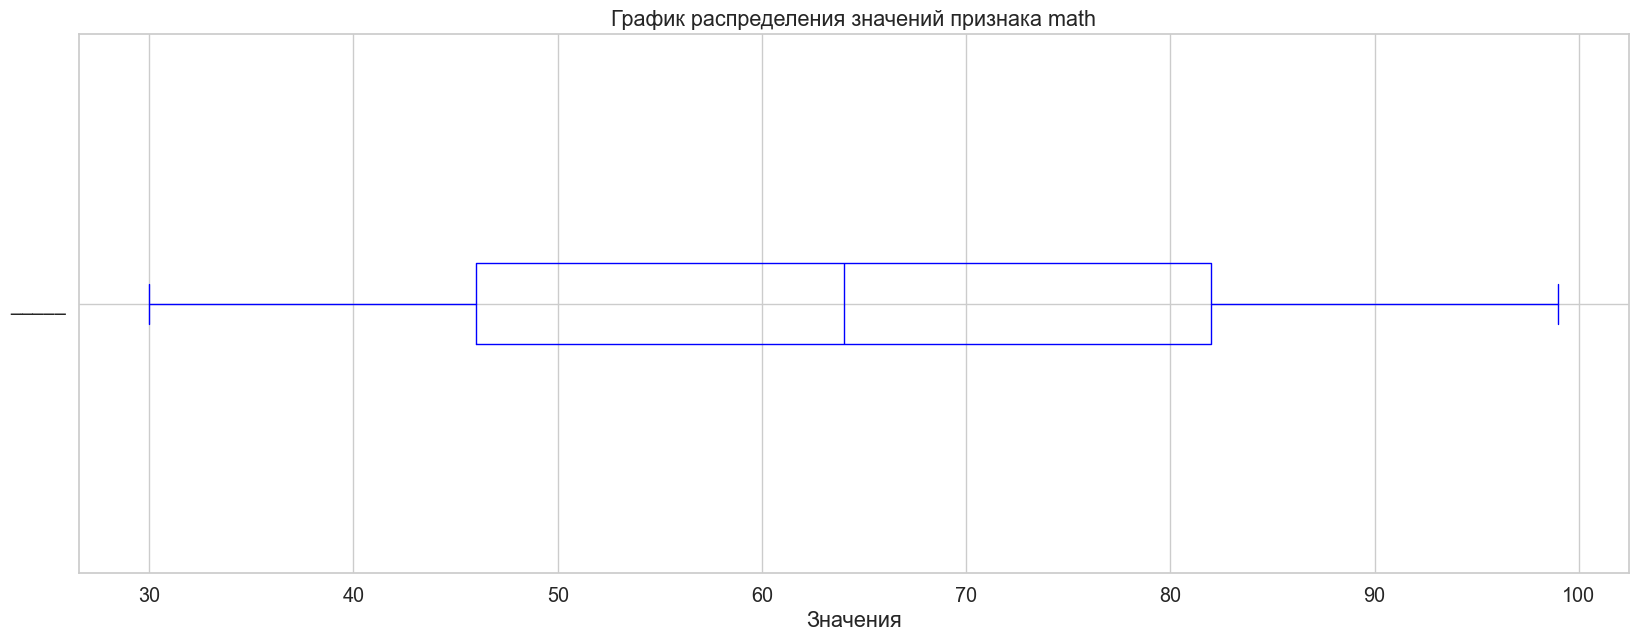

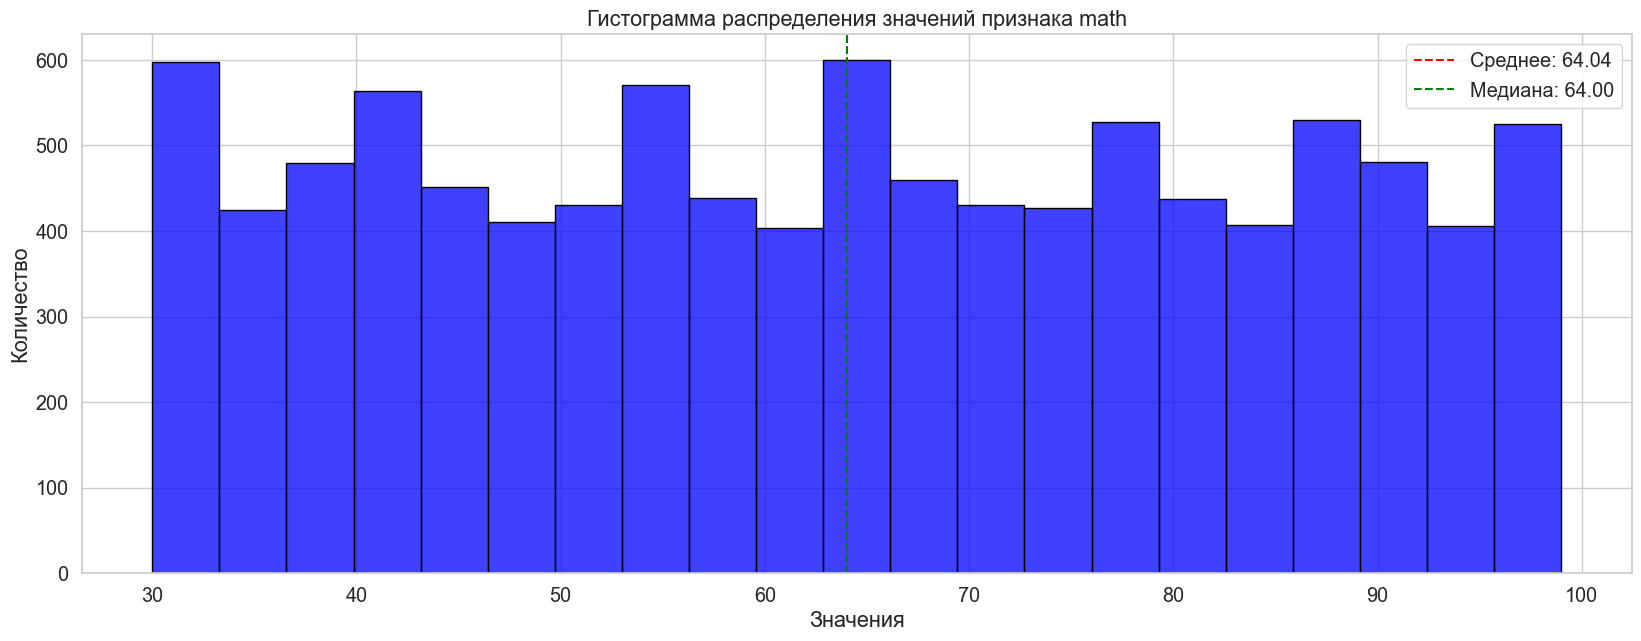

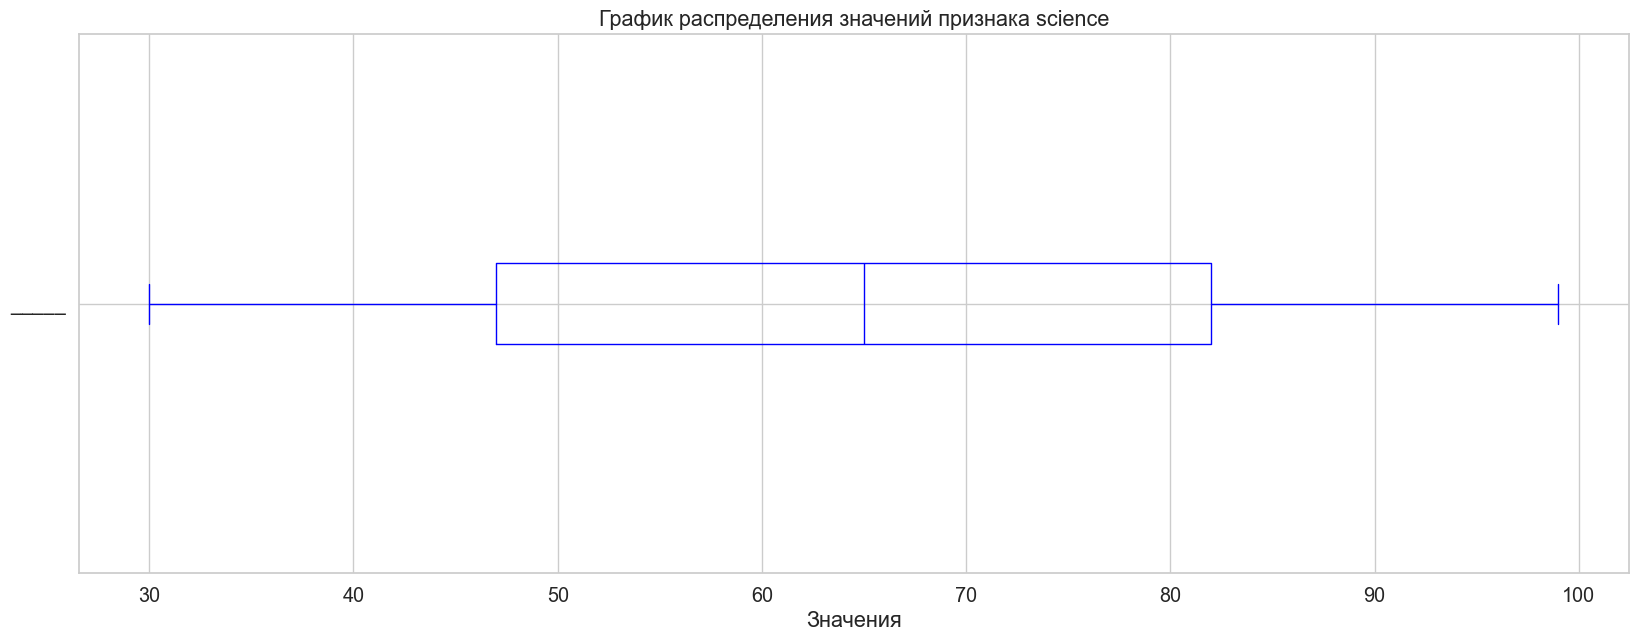

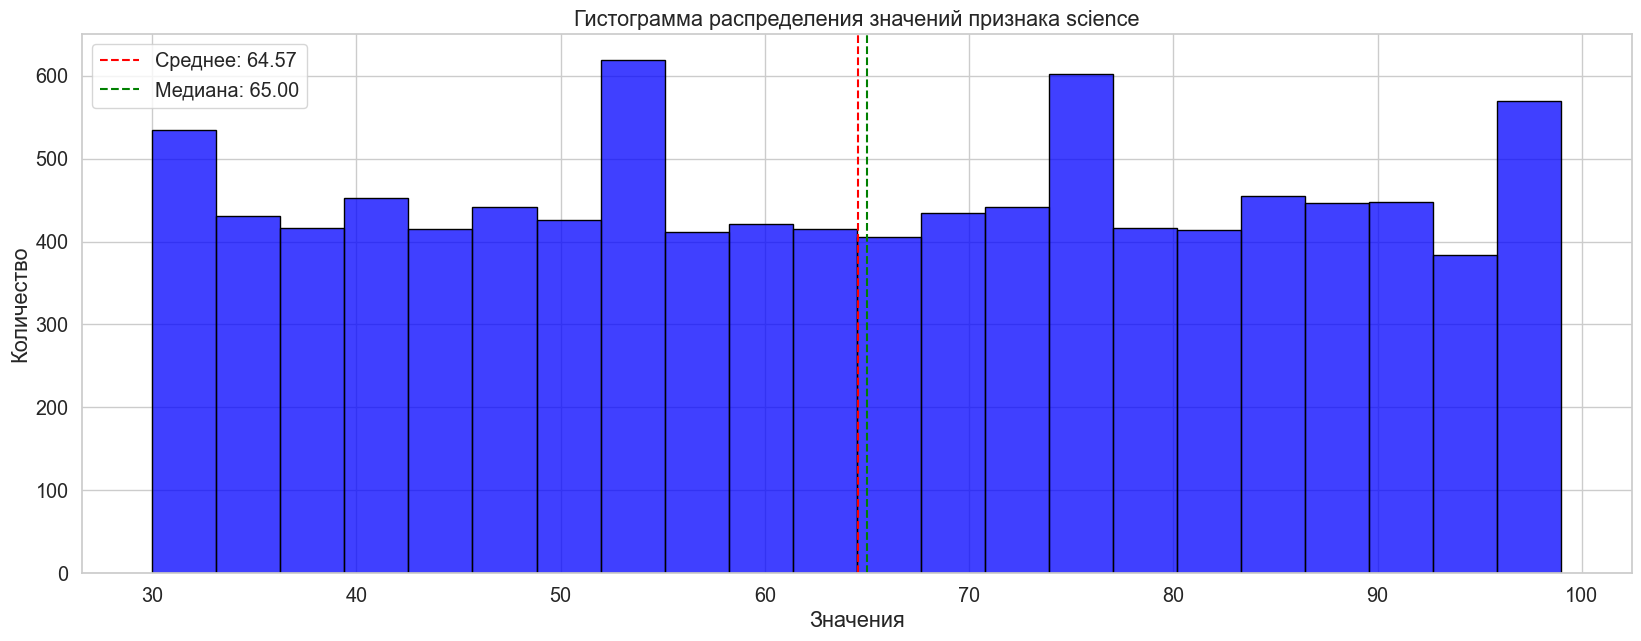

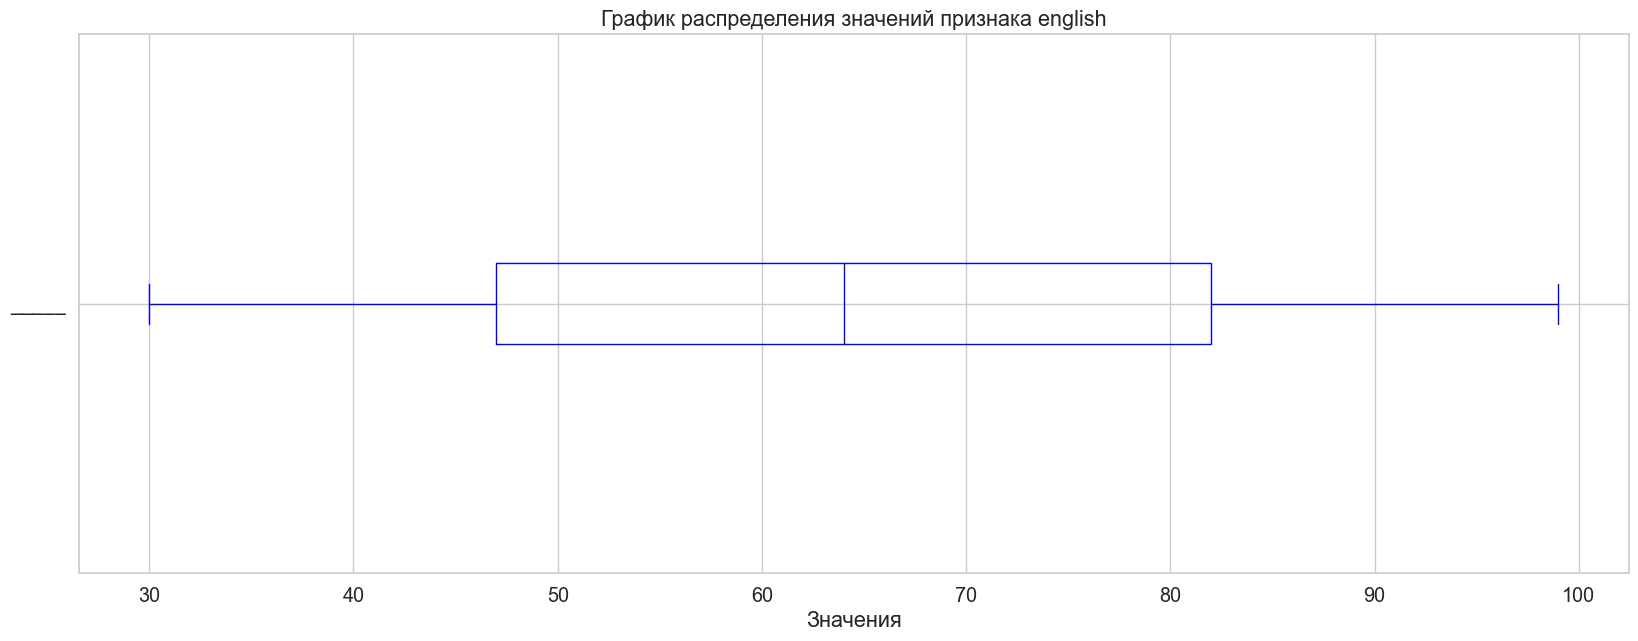

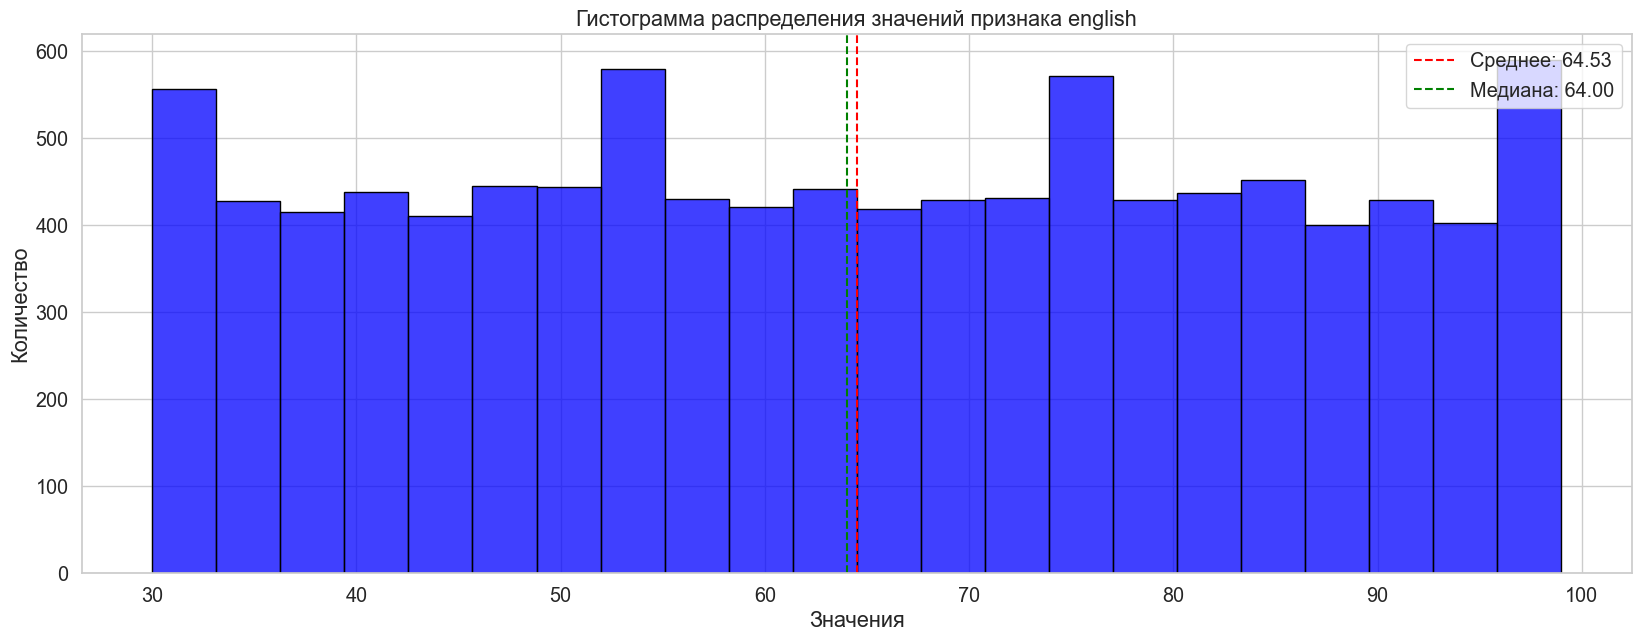

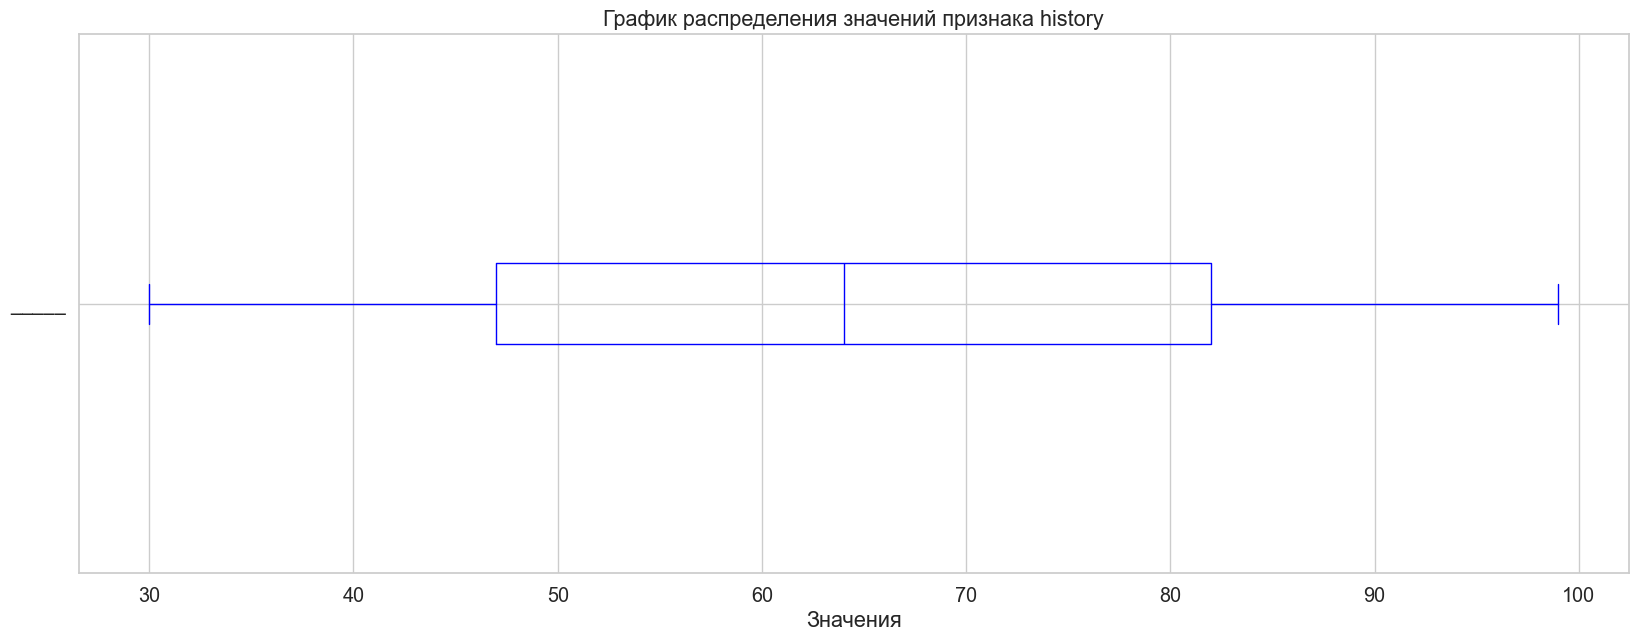

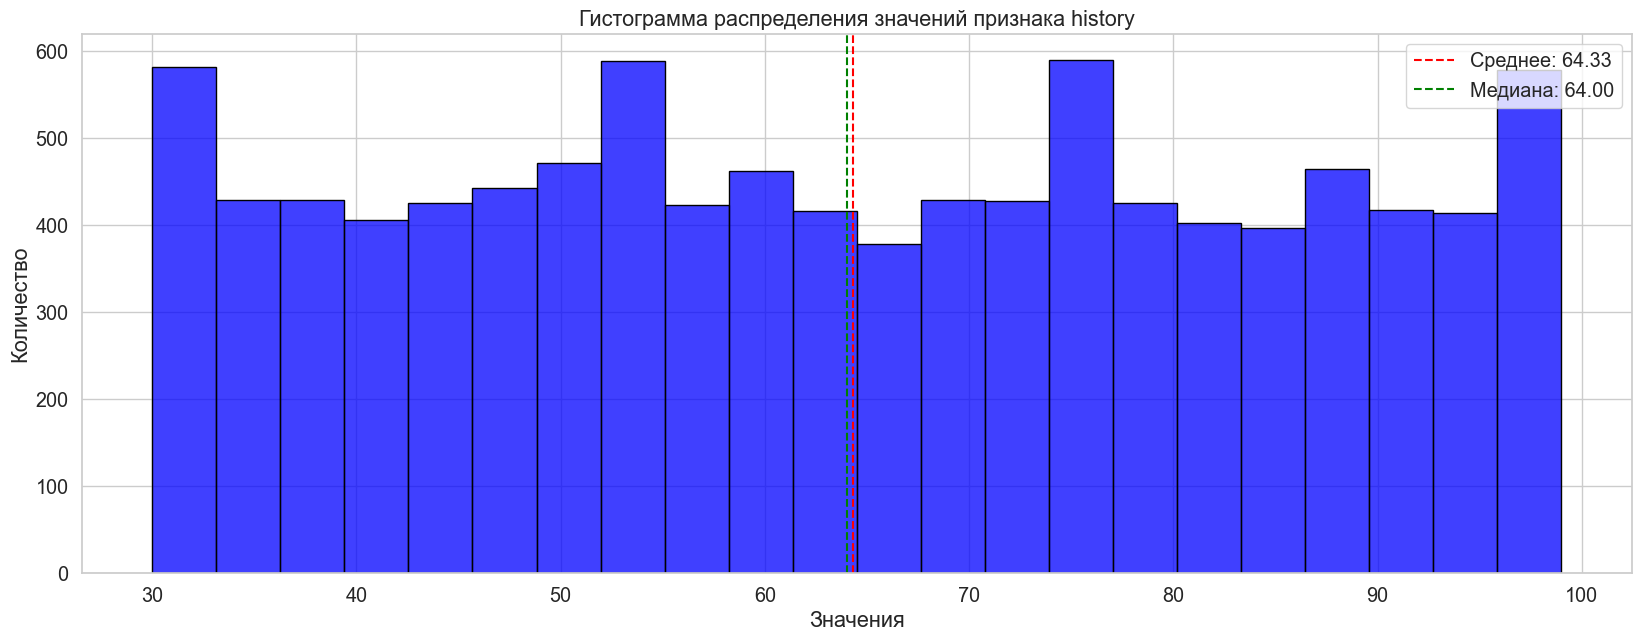

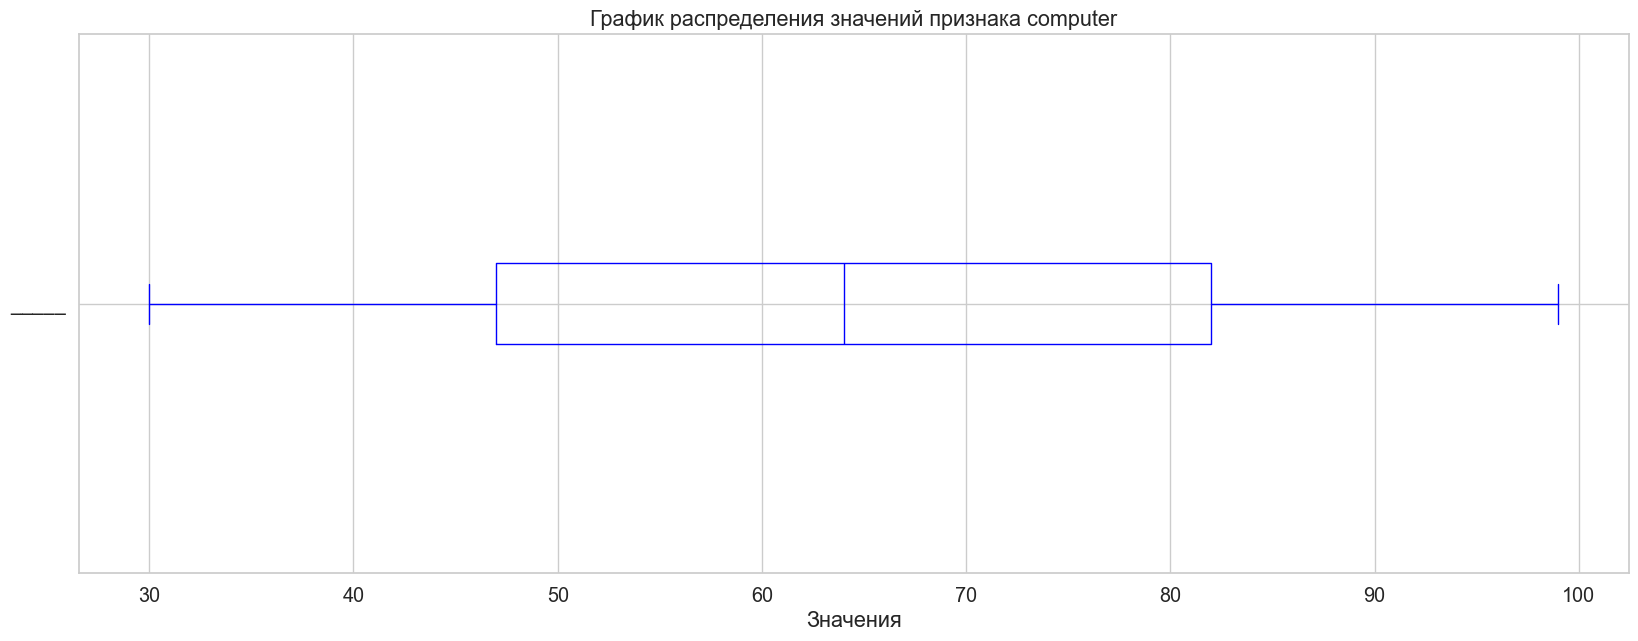

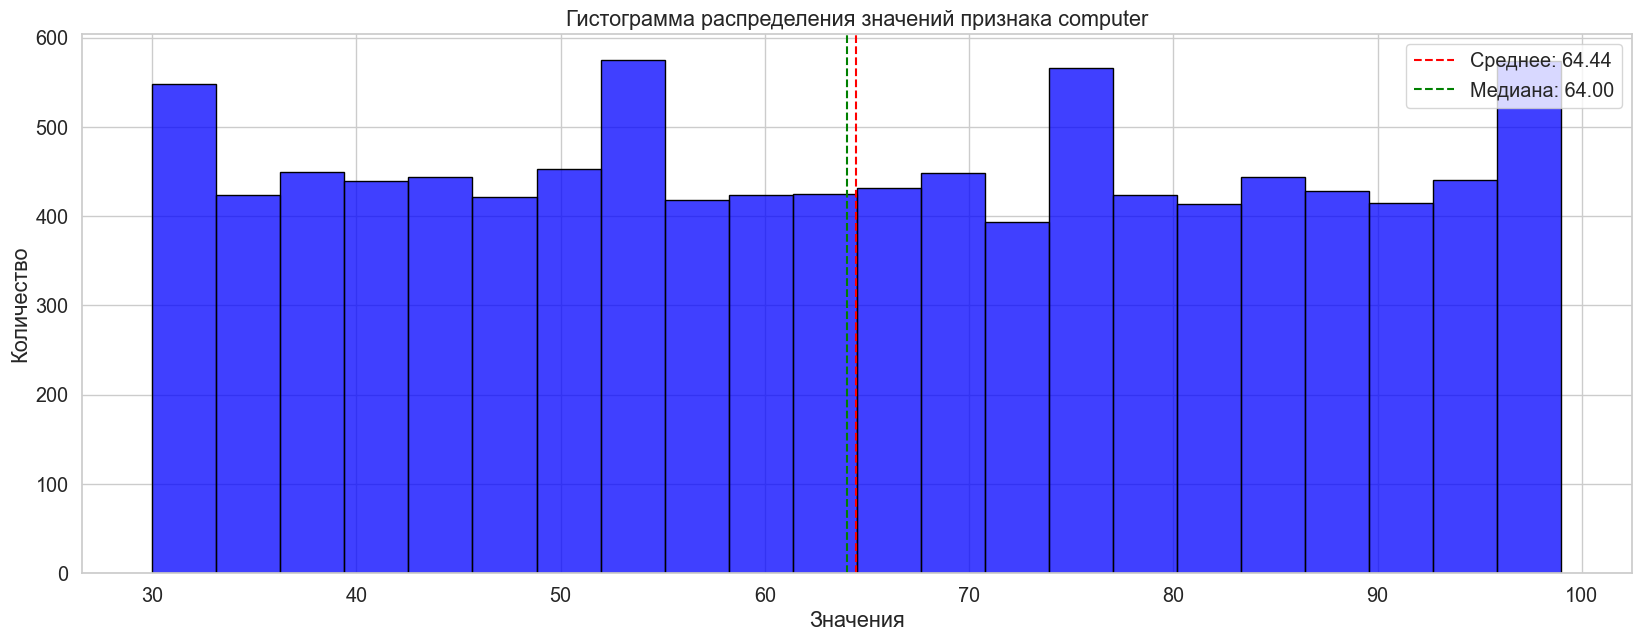

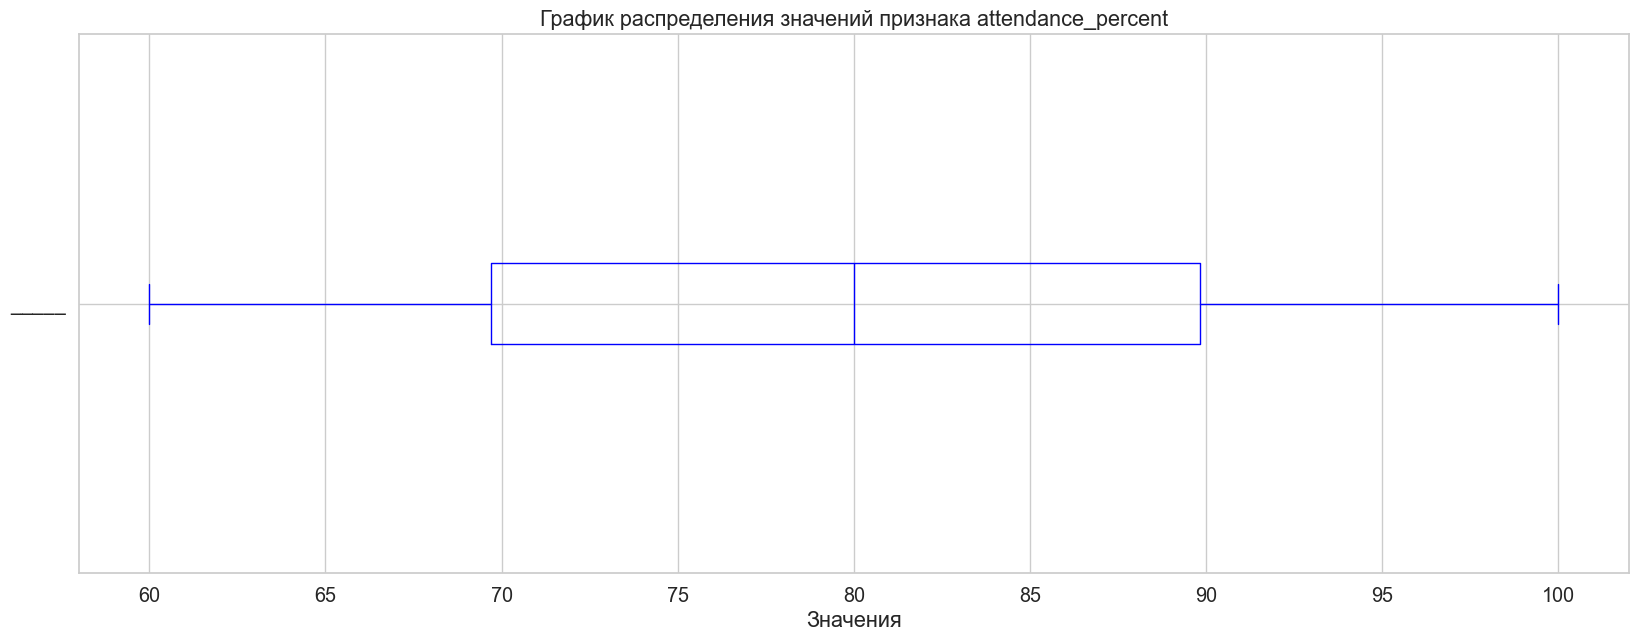

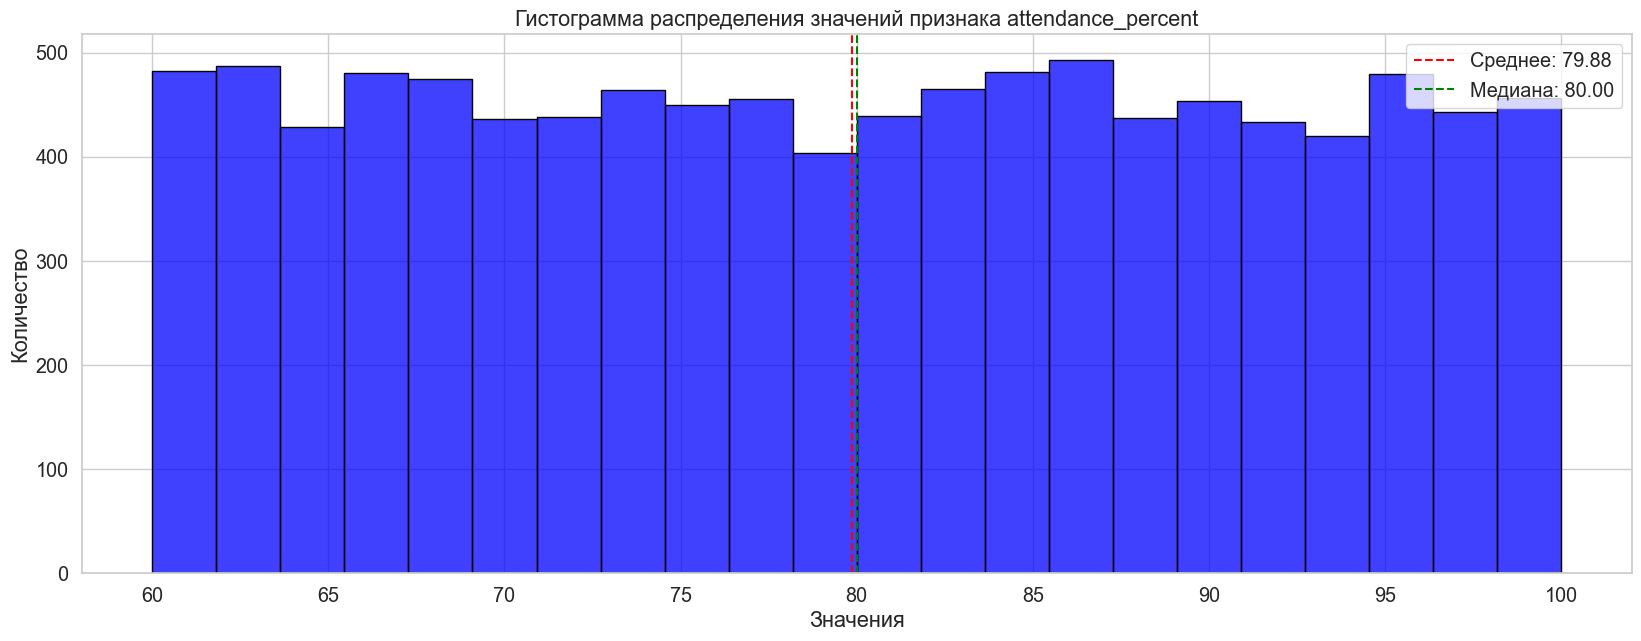

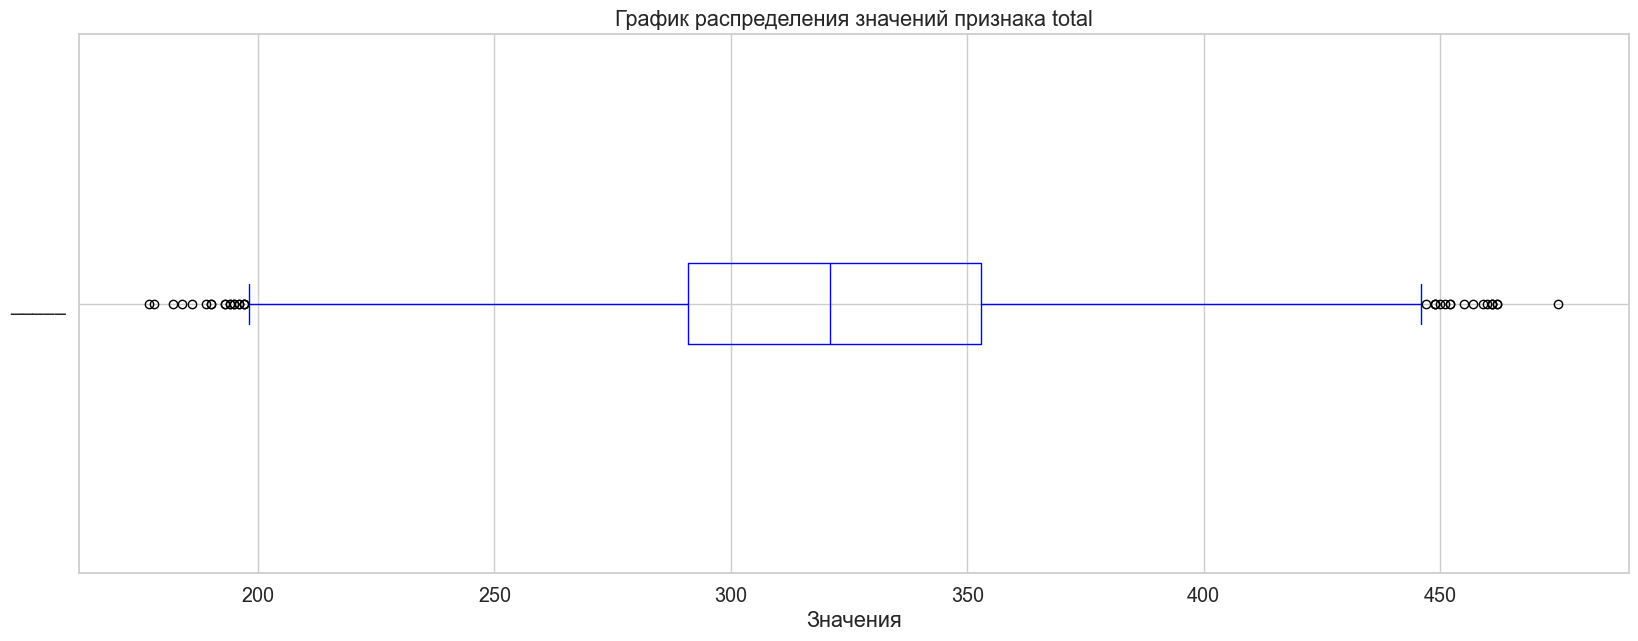

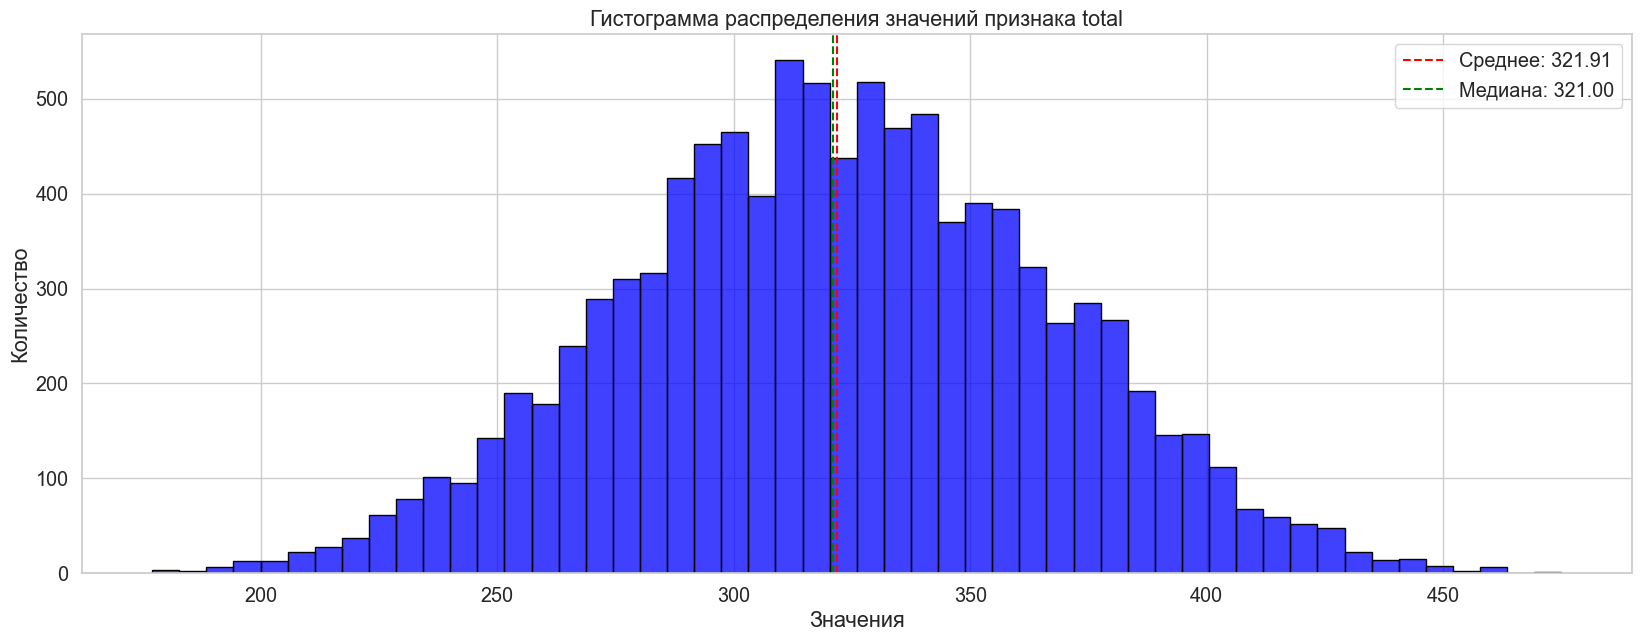

In [16]:
quan_columns = [ 
    'math',
    'science', 
    'english', 
    'history', 
    'computer',
    'attendance_percent', 
    'total'
]

for i in quan_columns:
    # График Boxplot
    students.boxplot([i], vert=False, color='blue')
    plt.title('График распределения значений признака '+i)
    plt.xlabel('Значения')
    plt.yticks([1], ['_____'])
    plt.show();

    # Гистограмма
    sns.histplot(students[i], color='blue', edgecolor='black')
    plt.title('Гистограмма распределения значений признака '+i)
    plt.axvline(students[i].mean(), color='red', linestyle='--', label=f"Среднее: {students[i].mean():.2f}")
    plt.axvline(students[i].median(), color='green', linestyle='--', label=f"Медиана: {students[i].median():.2f}")
    plt.xlabel("Значения")
    plt.ylabel("Количество")
    plt.legend()
    plt.show();

**Выводы по шагу 3.1:**

Гистограммы и боксплоты показывают, что распределение оценок по отдельным предметам у большинства студентов сосредоточено в диапазоне 60-70 баллов, с межквартильным размахом, охватывающим примерно 46-82 баллов, и средними/медианными значениями около 64-65 баллов, что указывает на симметричное распределение. Процент посещаемости ("attendance_percent") также демонстрирует симметричное распределение. Здесь большинство студентов имеют посещаемость 70-90%, со средним значением около 79-80%, что говорит о низкой дисперсии. Гистограмма общей суммы баллов ("total") имеет более широкий диапазон (200-450 баллов), с пиком около 320 баллов, что отражает нормальное распределение с незначительными выбросами. В целом, данные свидетельствуют о стабильных средних результатах студентов по всем предметам, умеренной вариации в общей сумме баллов и высокой посещаемости с небольшим разбросом.

### Шаг 3.2 Распределение категориальных данных

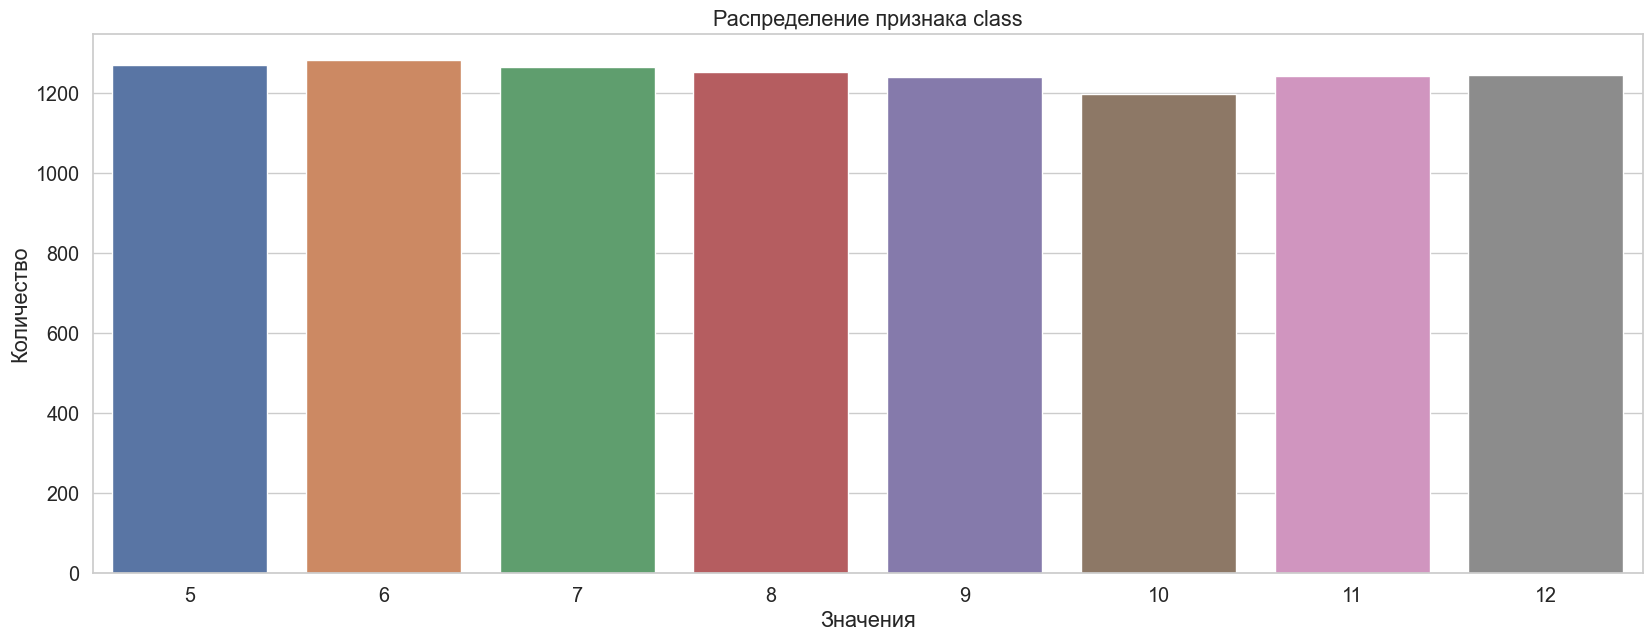

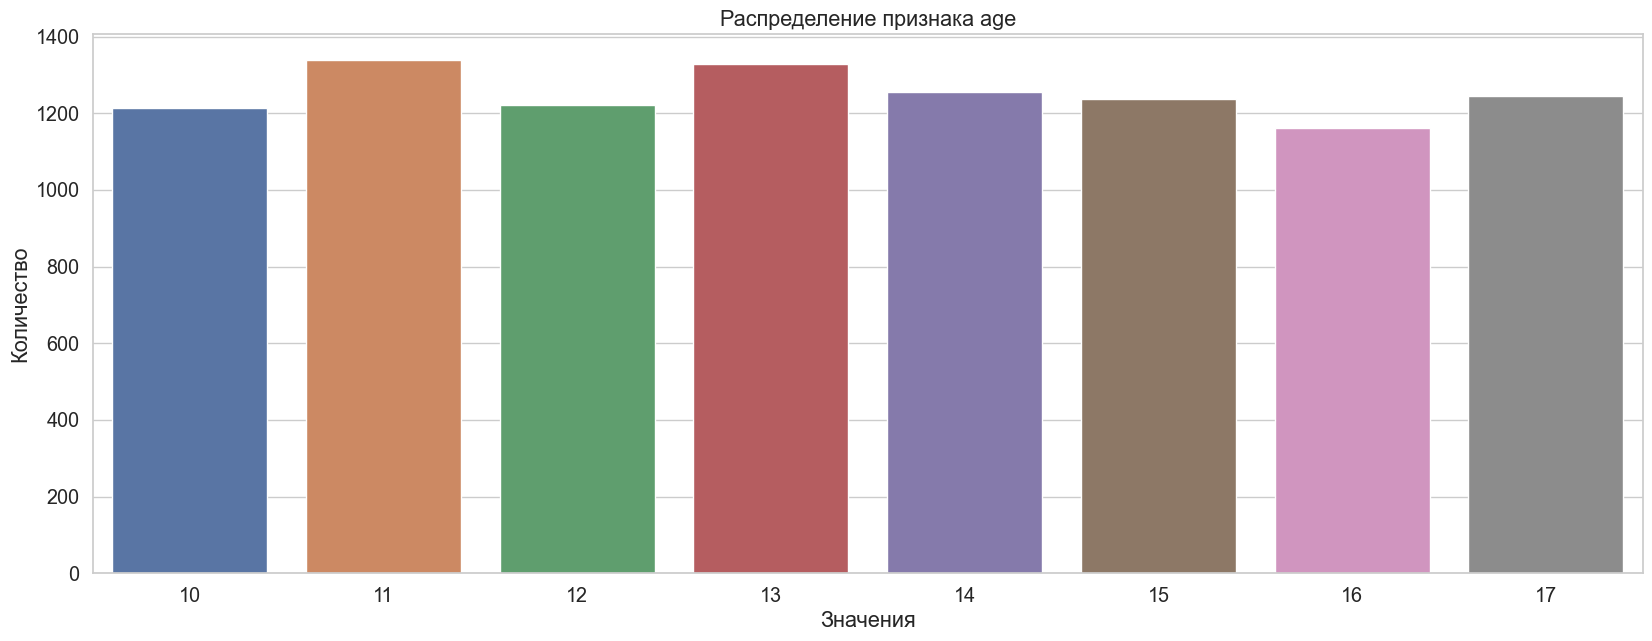

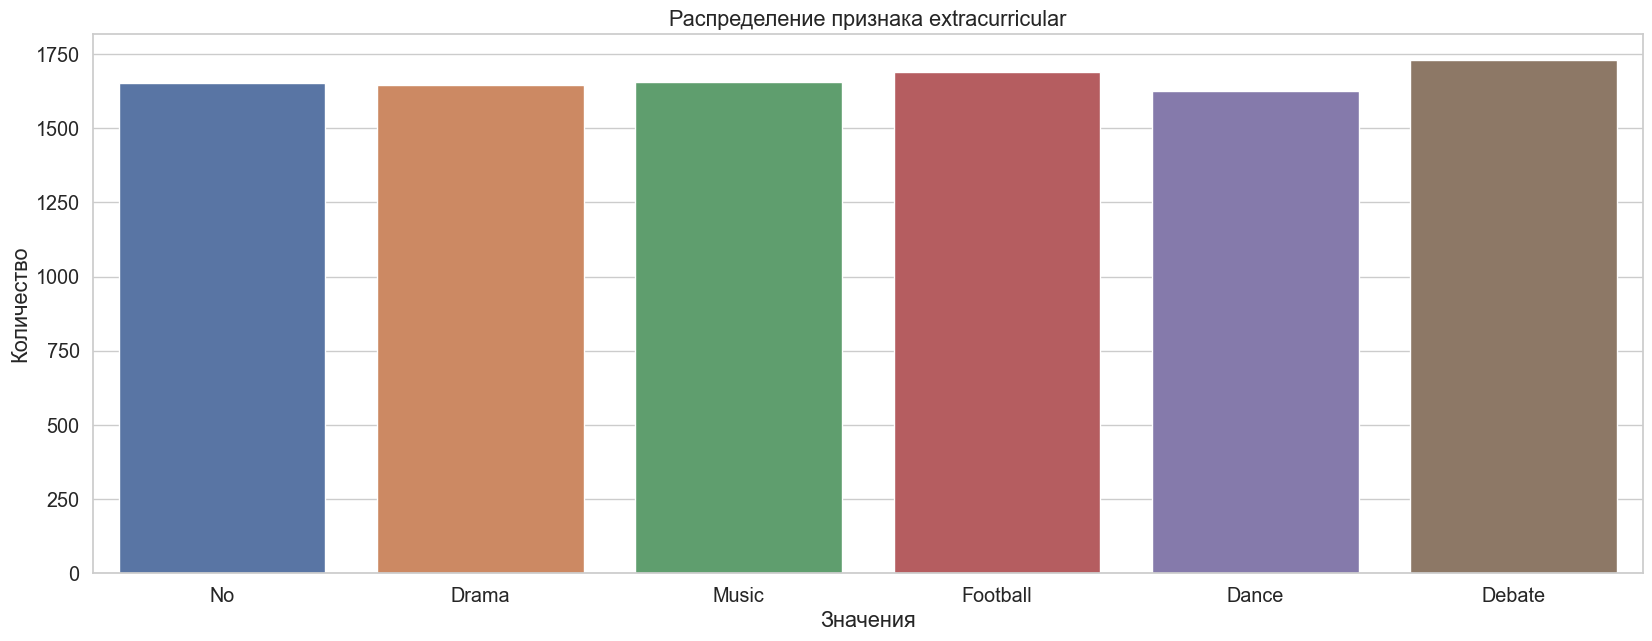

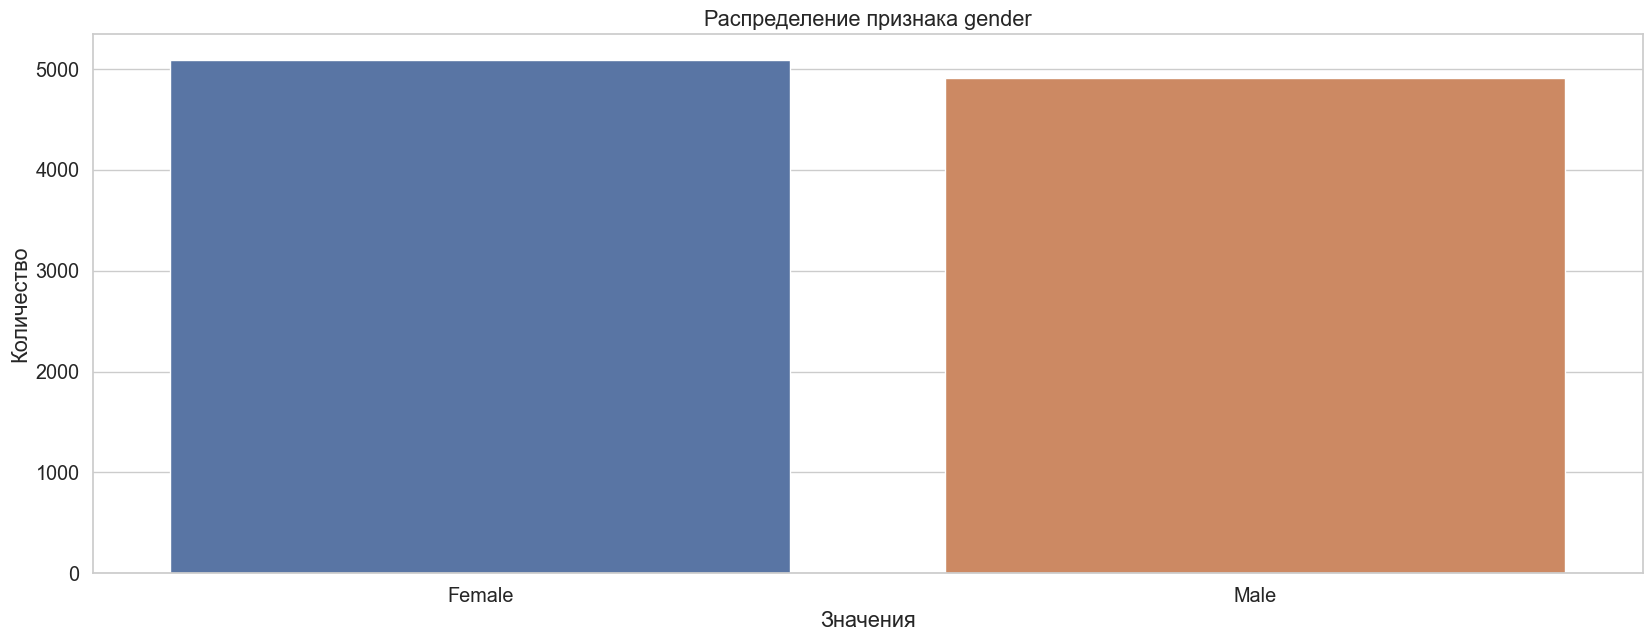

In [19]:
cat_columns = [
    'class',
    'age',    
    'extracurricular',
    'gender'
]

for y in cat_columns:
    sns.countplot(x=students[y])
    plt.title(f"Распределение признака {y}")
    plt.xlabel("Значения")
    plt.ylabel("Количество")
    plt.show()

**Выводы по шагу 3.2:**

Столбчатые диаграммы распределения студентов по классам и возрасту очень схожи, что неудивительно, так как эти показатели прямопропорциональны: чем ниже класс, тем ниже возраст и наоборот. Среди внеучебных занятий ("extracurricular") наибольшее количество студентов участвуют в дебатах, однако этот отрыв совсем мизерный. По полу распределение близко к равному: чуть более 5000 девушек и около 5000 мальчиков. В целом, все диаграммы показывают равномерное распределение лишь с небольшими вариациями.

### Шаг 3.3 Корреляция успеваемости студента по отдельным предметам и общей итоговой оценкой

В обществе принято условное деление на технарей и гуманитарев. Тех, кто преуспевает в естественных науках, записывают в технари, а любителей истории, литературы или обществознания относят к гуманитариям. Поэтому я решил проверить, есть ли корреляция между успеваемостью студента в определенной дисциплине с общей итоговой оценкой. Например, может итоговую высокую оценку А больше получают технари, у которых высокие баллы в математике или же лидируют гуманитарии, у которых отличные показатели по истории?

Чтобы это выяснить, я разбил предметные баллы на 5 категорий:

- оценка 5: 90–100 (высокие баллы, отличная успеваемость)
- оценка 4: 80–89 (хорошие баллы, выше среднего)
- оценка 3: 70–79 (средние баллы, удовлетворительная успеваемость)
- оценка 2: 60–69 (низкие баллы, минимально допустимая успеваемость)
- оценка 1: 30–59 (неудовлетворительные баллы, провал)

Далее выполняем разбивку баллов:

In [23]:
# создаем новый датасет students_copy, чтобы не менять прежний

students_copy = students.drop(['age','gender','class','attendance_percent','extracurricular','total'], axis=1).copy()

# Интервалы и числовые категории

bins = [0, 59, 69, 79, 89, 100]
score_categories = [1, 2, 3, 4, 5]

# Список предметов

subject_columns = ['math', 'science', 'computer', 'english', 'history']

# Применим ко всем предметам

for col in subject_columns:
    students_copy[col] = pd.cut(students_copy[col], bins=bins, labels=score_categories, right=True, include_lowest=True).astype(int)

# выводим для ознакомления
students_copy.head()

,math,science,english,history,computer,grade
0,1,4,2,2,4,C
1,1,5,1,2,3,C
2,3,1,1,4,5,C
3,3,3,1,1,5,C
4,4,3,4,1,3,C


Далее выводим графики для каждой дисциплины в разрезе итоговой оценки.

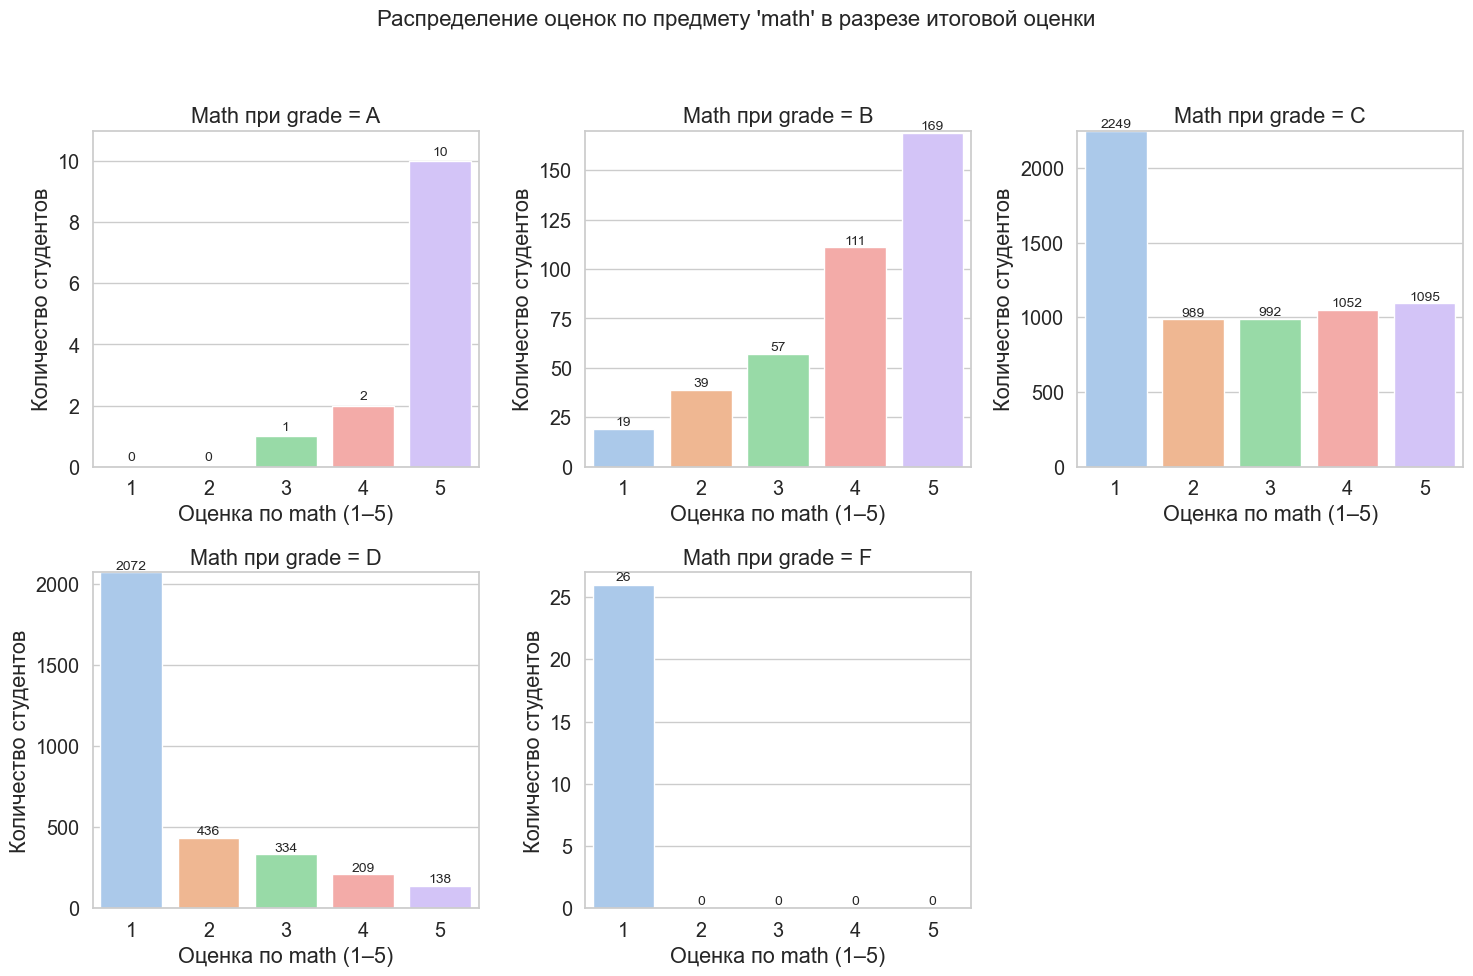

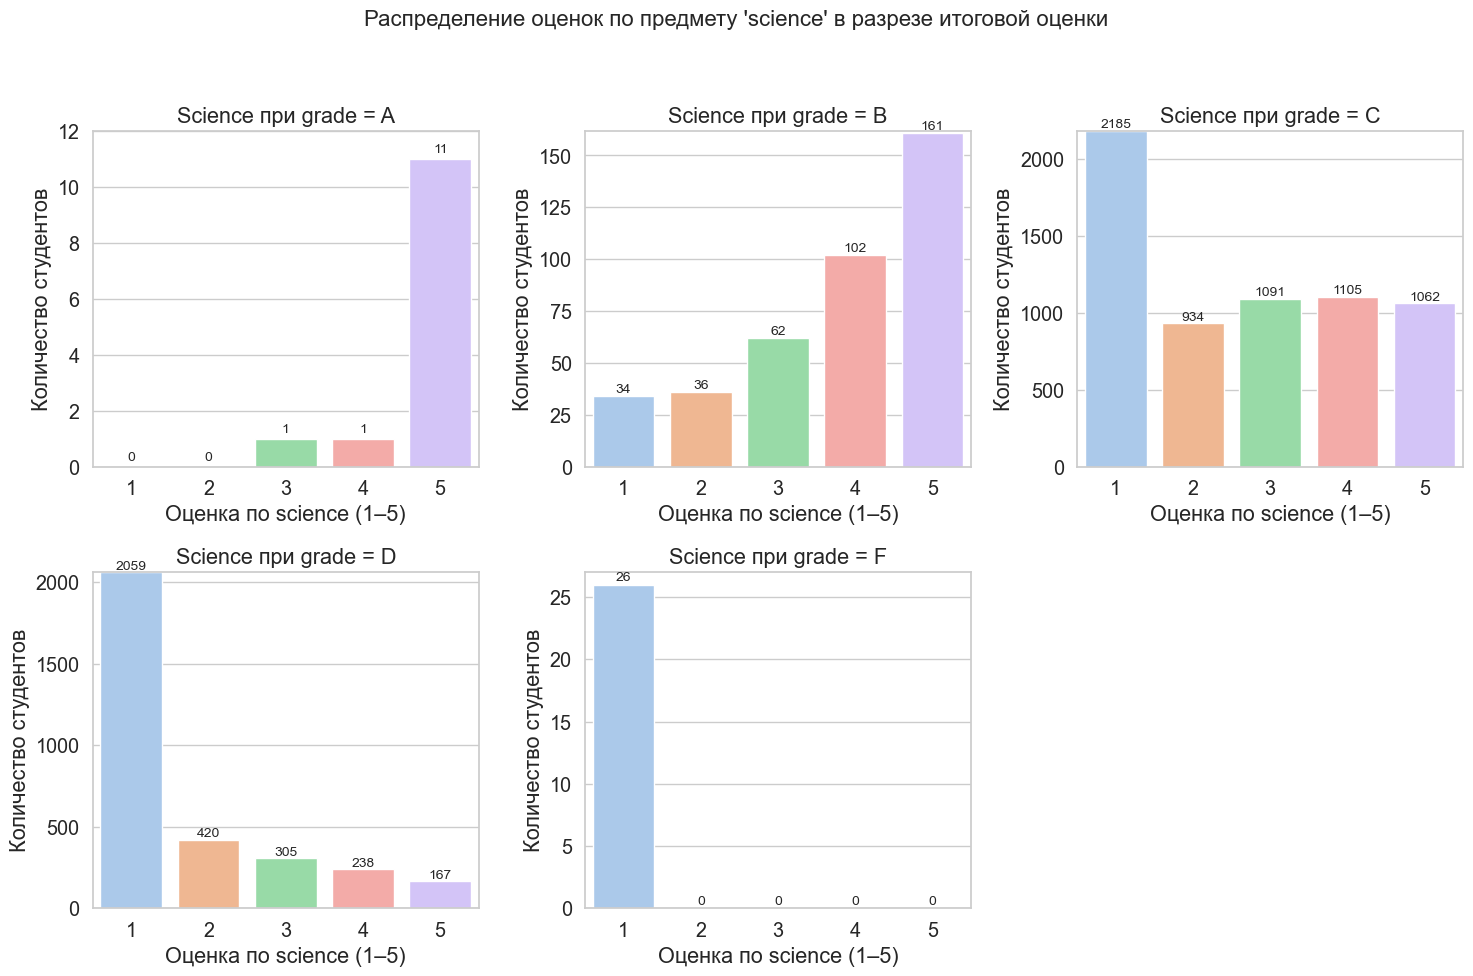

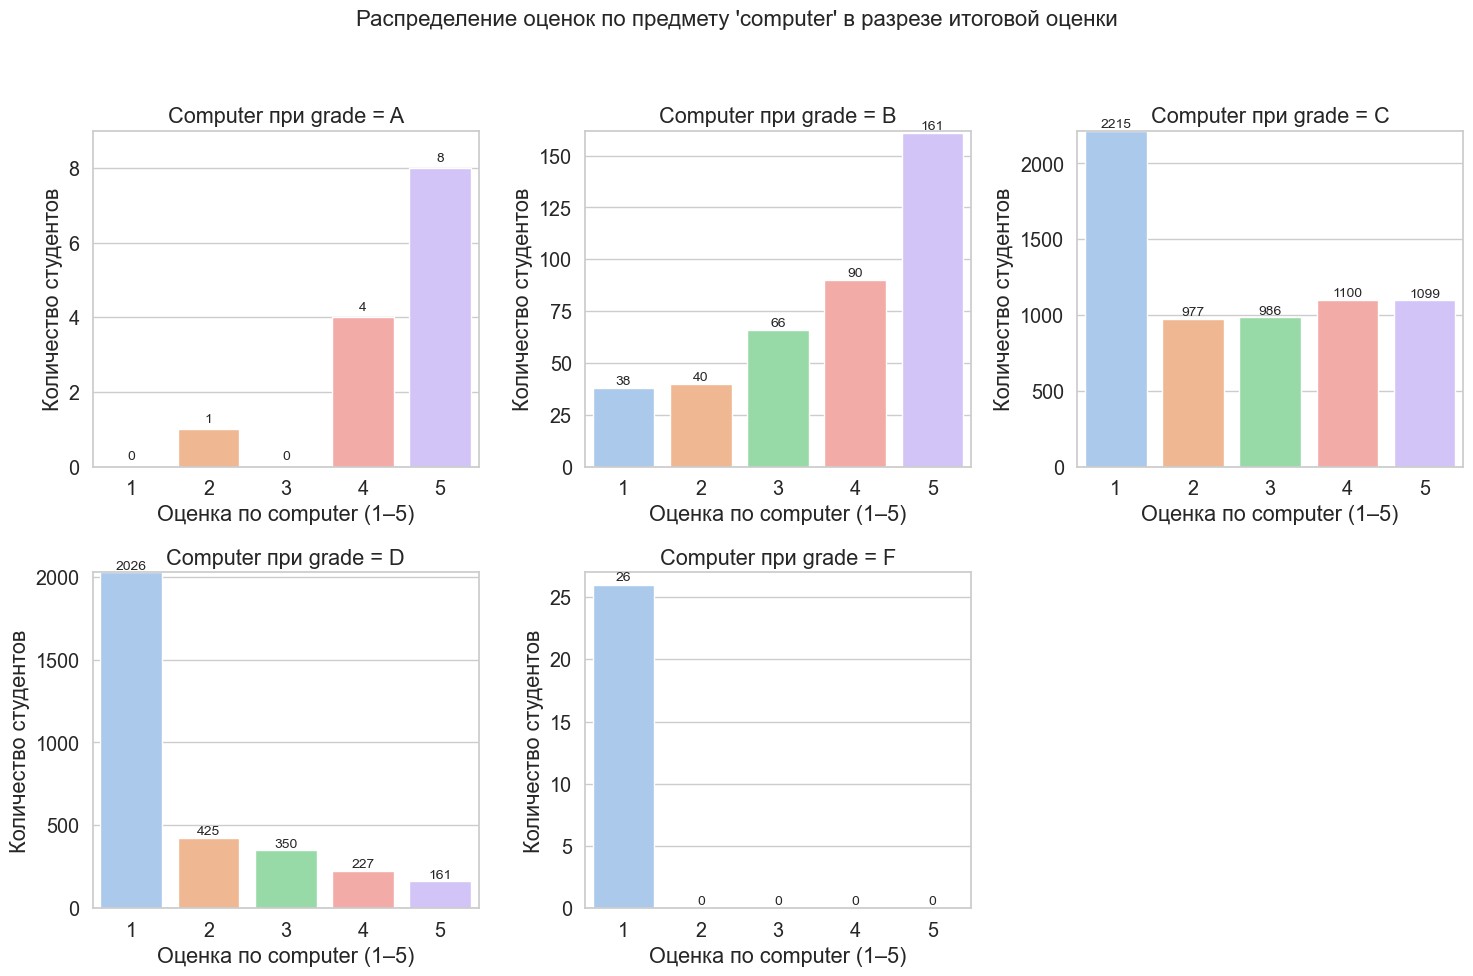

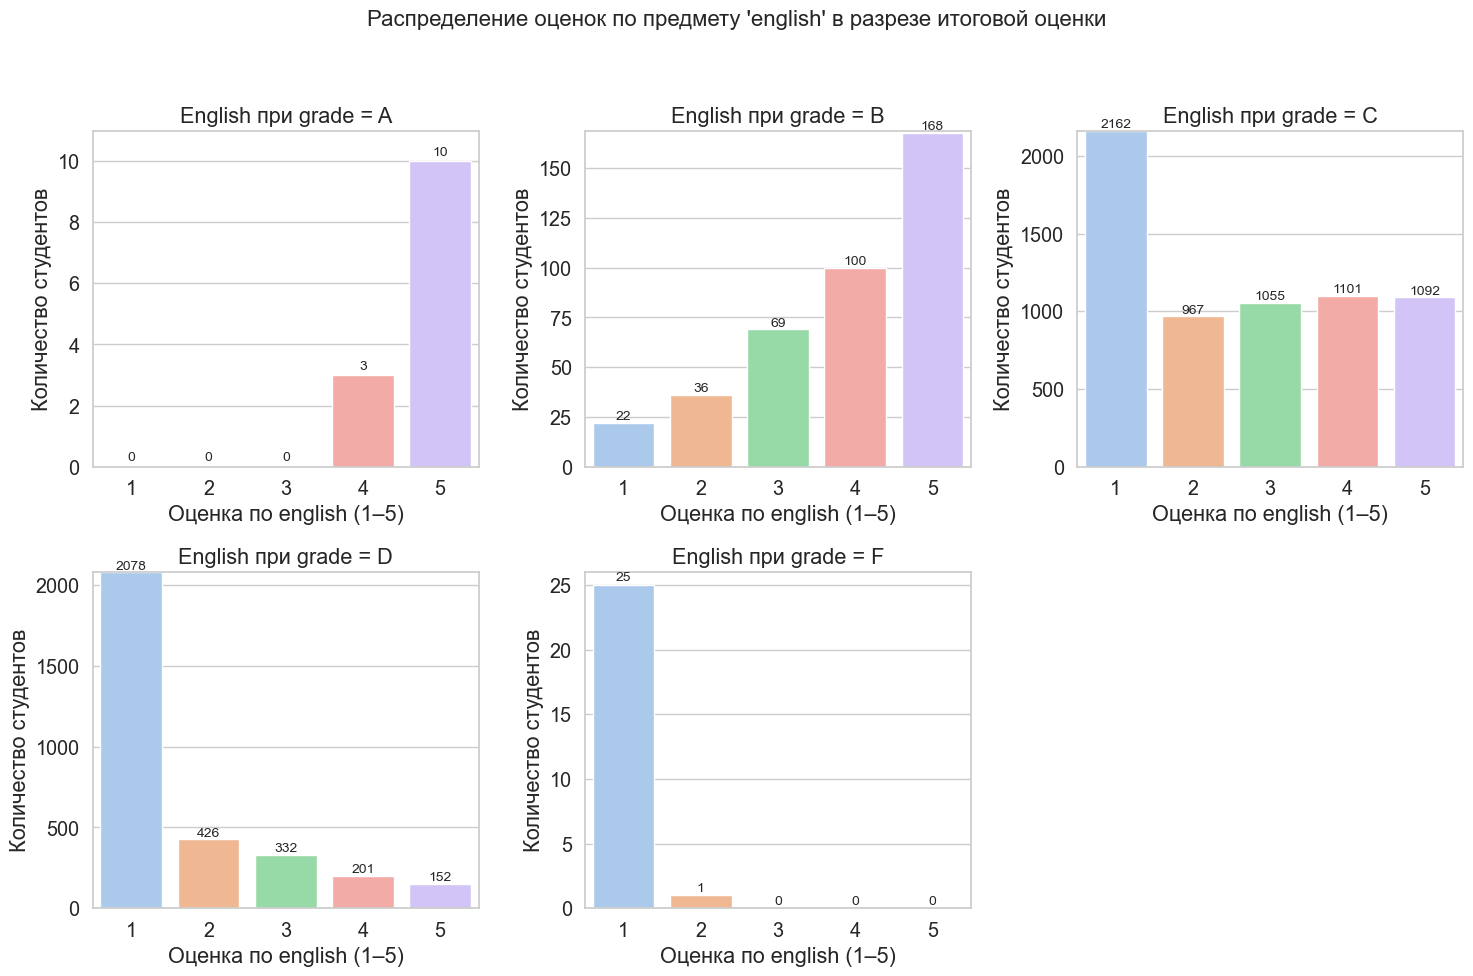

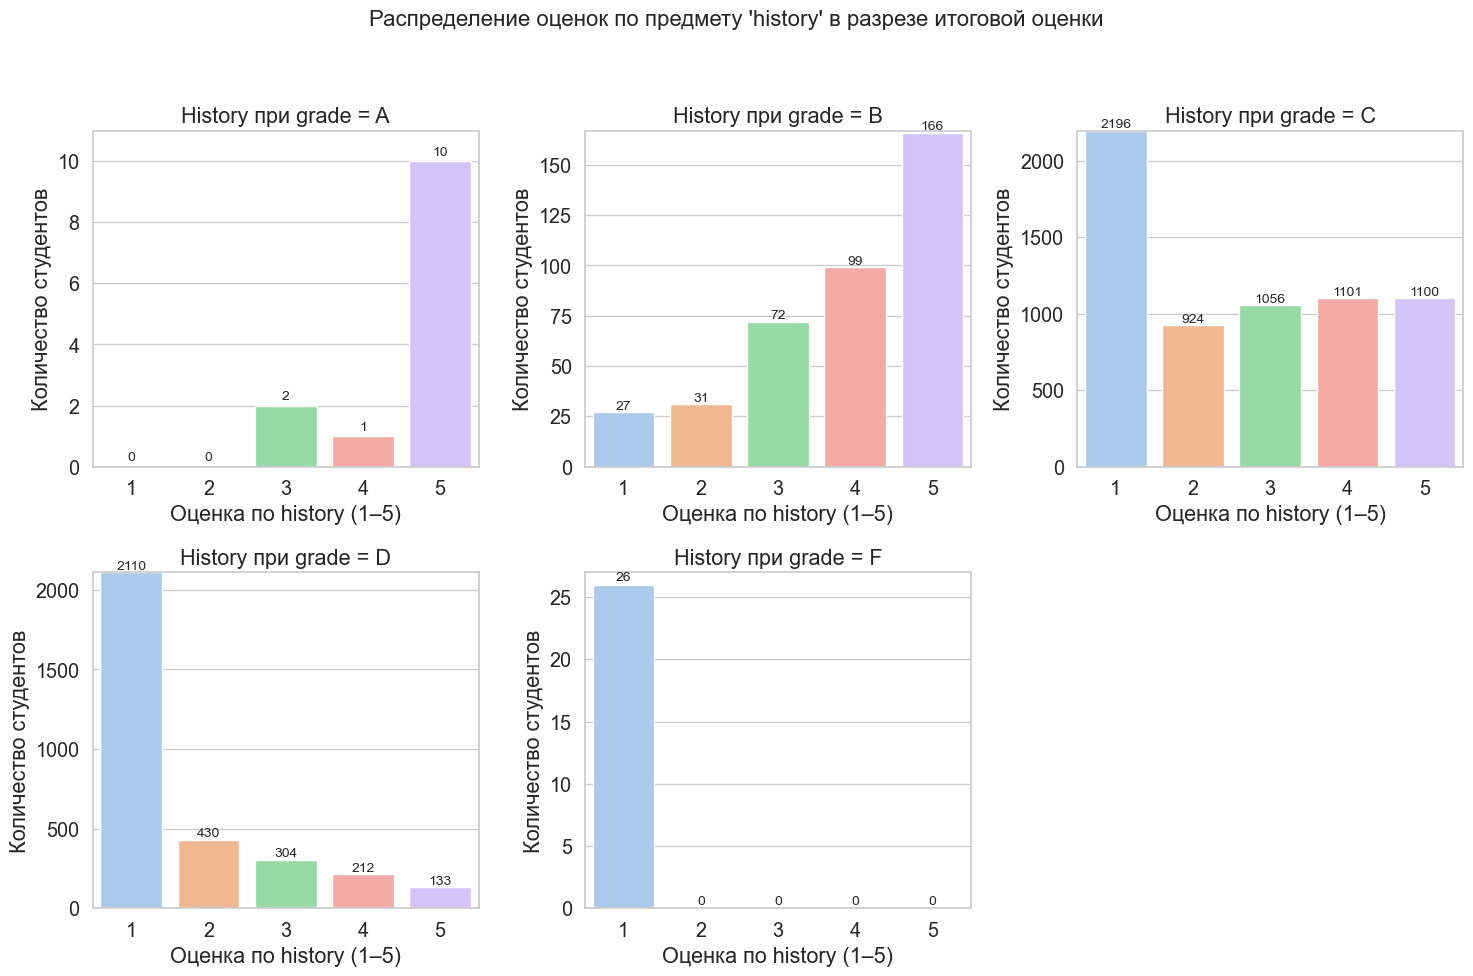

In [25]:
# Порядок итоговых оценок
grade_order = ['A', 'B', 'C', 'D', 'F']

# Проходимся по каждому предмету
for subject in subject_columns:
    plt.figure(figsize=(15, 10))
    
    for i, grade in enumerate(grade_order):
        plt.subplot(2, 3, i + 1)

        # Отбираем студентов с итоговой оценкой grade
        subset = students_copy[students_copy['grade'] == grade]

        # Считаем частоты оценок по текущему предмету
        value_counts = subset[subject].value_counts().reindex(score_categories, fill_value=0)

        ax = sns.barplot(
            x=value_counts.index,  # Оценки (1, 2, 3, 4, 5)
            y=value_counts.values, # Количество студентов
            order=score_categories, # Явно задаем порядок категорий
            palette="pastel"
        )

        # Добавим подписи над столбцами
        for bar in ax.patches:  # Перебираем столбцы напрямую
            height = bar.get_height()  # Высота столбца
            x_pos = bar.get_x() + bar.get_width() / 2  # Центр столбца по оси X
            ax.text(x_pos, height + 0.1, f'{int(height)}', ha='center', va='bottom', fontsize=10)

        plt.title(f"{subject.capitalize()} при grade = {grade}")
        plt.xlabel(f"Оценка по {subject} (1–5)")
        plt.ylabel("Количество студентов")
        plt.ylim(0, value_counts.values.max() + 1)

    plt.suptitle(f"Распределение оценок по предмету '{subject}' в разрезе итоговой оценки", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Оставляем место для заголовка
    plt.show()

**Выводы по шагу 3.3:**

Среди отличников, получивших высокую итоговую оценку "А", находится следующее количество отличников:

- отличники по математике: 10
- отличники по естественным наукам: 11
- отличники по информатике: 8
- отличники по английскому языку: 10
- отличники по истории: 10.

Среди хорошистов, получивших хорошую итоговую оценку "В", находится следующее количество отличников:

- отличники по математике: 169
- отличники по естественным наукам: 161
- отличники по информатике: 161
- отличники по английскому языку: 168
- отличники по истории: 166.

Среди аутсайдеров, получивших самую низкую итоговую оценку "F", находится следующее количество отстающих:

- аутсайдеры по математике: 26
- аутсайдеры по естественным наукам: 26
- аутсайдеры по информатике: 26
- аутсайдеры по английскому языку: 25
- аутсайдеры по истории: 26.

Судя по выведенной информации, итоговая оценка особо не коррелирует с преуспеваемостью студентов в определенной дисциплине. Значения рассеяны равномерно.

# Шаг 4. Корреляционный анализ данных

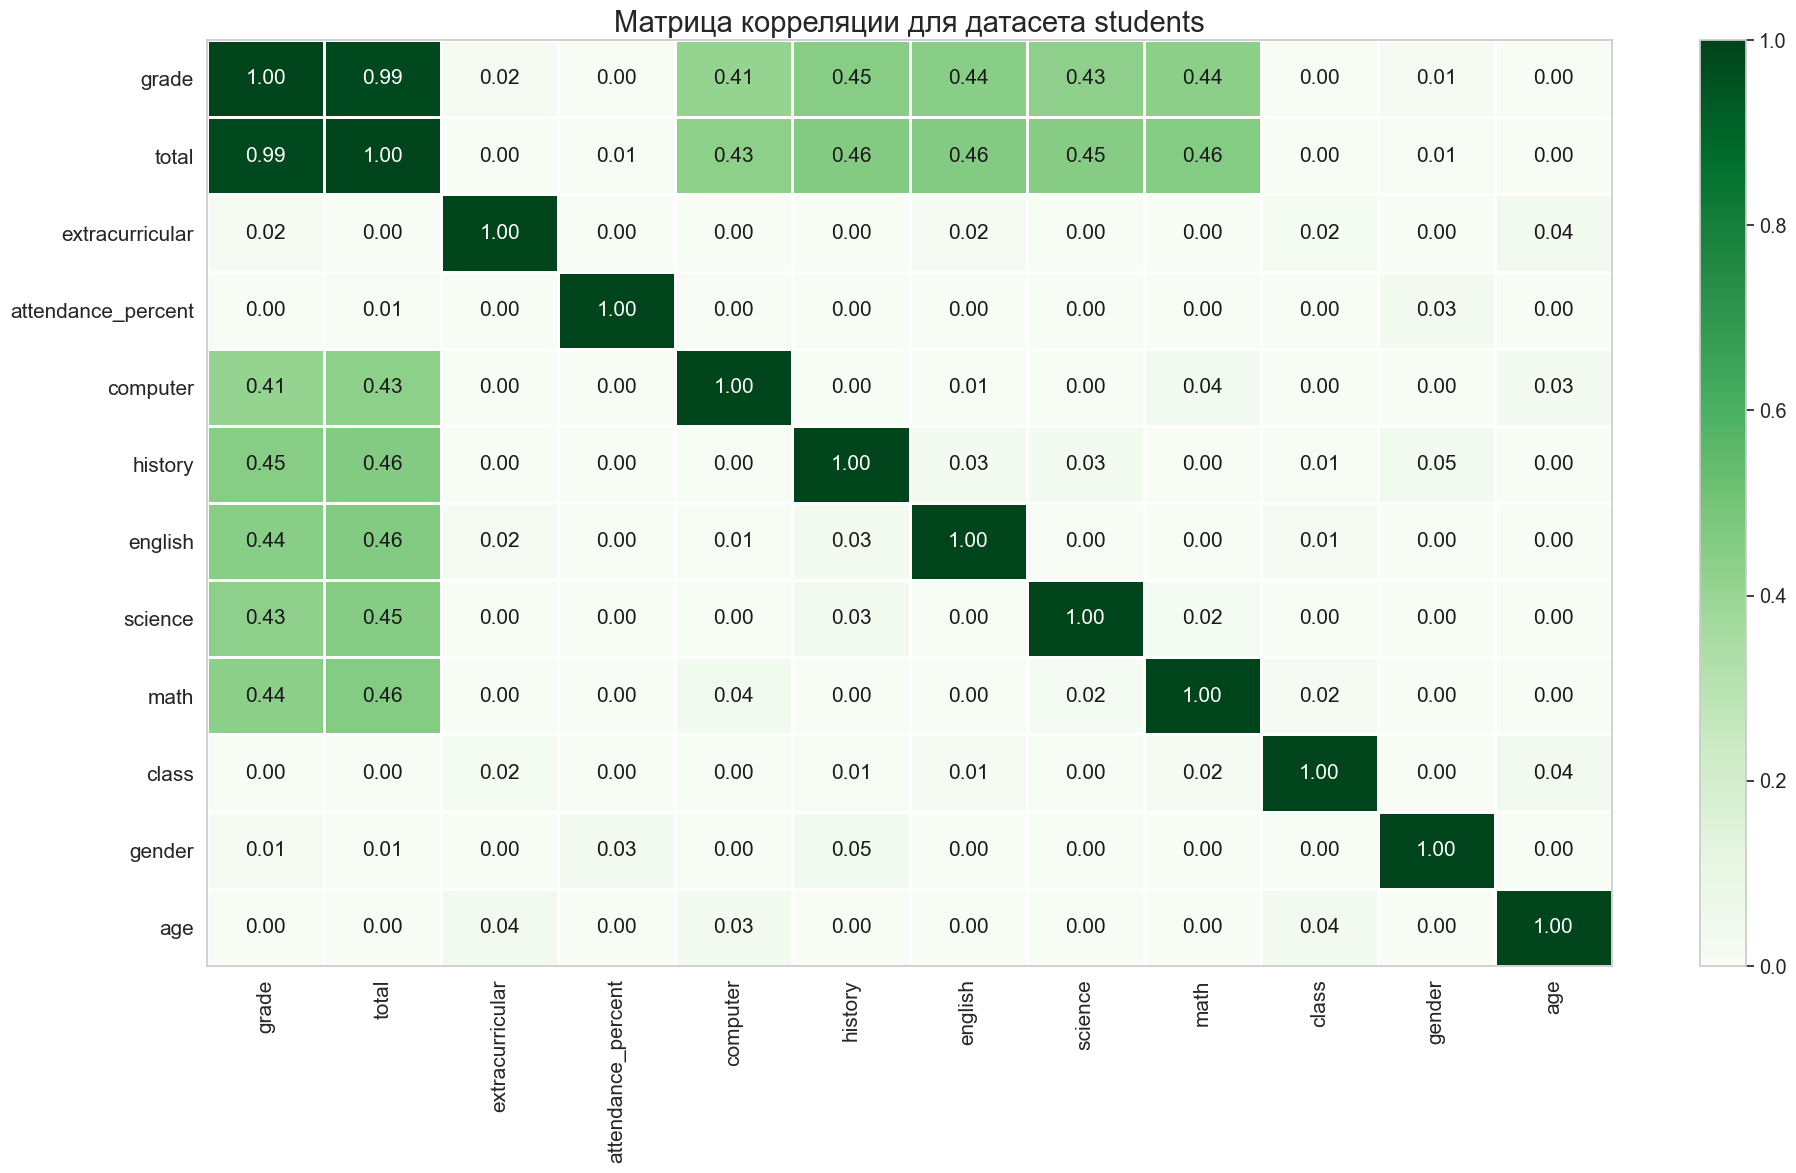

In [28]:
phik_overview = phik_matrix(students, interval_cols=[
                                                        'math',
                                                        'science', 
                                                        'english', 
                                                        'history', 
                                                        'computer',
                                                        'attendance_percent', 
                                                        'total'
                                                    ])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции для датасета students',
    fontsize_factor=1.5,
    figsize=(20, 12)
)

Признаки 'extracurricular', 'attendance_percent', 'class', 'gender', 'age' никак не коррелируют с целевым признаком 'grade' и не несут никакой предсказательной силы для модели машинного обучения. И совсем противоположная ситуация с признаком 'total', который практически на 100% коррелирует с целевым признаком. Дело в том, что итоговая оценка напрямую формируется исходя из значений признака 'total'. Другими словами, признак 'total' - это и есть целевой признак 'grade', но только выраженный в числовом виде. Следовательно, нахождение признака 'total' среди входных признаков приведет к утечке данных, а значит, его тоже нужно удалить.

In [30]:
# удаляем лишние признаки

students = students.drop(['total', 'extracurricular', 'attendance_percent', 'class', 'gender', 'age'], axis=1)

In [55]:
# выводим итоговы результат

display(students.head())
display(students.info())

,math,science,english,history,computer,grade
0,47,85,67,68,81,3
1,40,94,42,66,70,3
2,71,59,30,88,94,3
3,72,78,32,38,92,3
4,87,79,84,53,77,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   math      10000 non-null  int64
 1   science   10000 non-null  int64
 2   english   10000 non-null  int64
 3   history   10000 non-null  int64
 4   computer  10000 non-null  int64
 5   grade     10000 non-null  int64
dtypes: int64(6)
memory usage: 468.9 KB


None

**Выводы по шагу 4:**

В ходе анализа таблицы корреляции обнаружились признаки, которые никак не коррелируют с целевым признаком. Также выявлен признак "total", который на 100% коррелирует с целевым признаком и приводит к утечке данных. Все признаки были удалены.

# Шаг 5. Обучение модели классификации

**Выбор модели**. Согласно матрице корреляции, коэффициенты корреляции Пирсона находятся в районе 0.40 - 0.45, что говорит о несильной линейной корреляции. Если бы линейная корреляция была бы сильная, то можно было бы обойтись и обычной моделью логистической регрессии. Но в нашем случае стоит опробовать более сложные модели классификации, помимо логистической. Поэтому опробуем на кросс-валидации несколько моделей ниже:

1) RandomForestClassifier (Случайный лес);
2) GradientBoostingClassifier (Градиентный бустинг);
3) LogisticRegression (как базовая модель для сравнения с остальными).

In [35]:
# Перевод целевого признака
grade_mapping = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'F': 1}
students['grade'] = students['grade'].map(grade_mapping)

# Входные и целевой признаки
X = students.drop(['grade'], axis=1)
y = students['grade']

# Тренировочная и тестовая выборка
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=17, stratify=y
)

# Базовый пайплайн (модель будет подставляться из параметров)
pipe = Pipeline([
    ('scaler', MinMaxScaler()),        # масштабирование MinMaxScaler, так как значения заключены в интервал от 0 до 100
    ('models', LogisticRegression())   # заглушка — будет заменена GridSearchCV
])

# Параметры для подбора
param_grid = [
    # RandomForestClassifier
    {
        'models': [RandomForestClassifier(random_state=17)],
        'models__n_estimators': [50, 100],
        'models__max_depth': [None, 5, 10]
    },
    
    # GradientBoostingClassifier
    {
        'models': [GradientBoostingClassifier(random_state=17)],
        'models__n_estimators': [50, 100],
        'models__learning_rate': [0.01, 0.1],
        'models__max_depth': [3, 5]
    },
    
    # LogisticRegression
    {
        'models': [LogisticRegression(solver='lbfgs', max_iter=200, random_state=17)],
        'models__C': [50, 100, 150]
    }
]

# Кросс-валидация и подбор модели
kf_cv = KFold(n_splits=5, shuffle=True, random_state=17)

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=kf_cv,
    scoring='accuracy',
    n_jobs=-1
)

# Обучение
grid_search.fit(X_train, y_train)

# Результаты
print("Лучшая модель:", grid_search.best_estimator_)
print("Лучшая точность на кросс-валидации:", round(grid_search.best_score_, 3))

Лучшая модель: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('models',
                 LogisticRegression(C=150, max_iter=200, random_state=17))])
Лучшая точность на кросс-валидации: 0.996


In [36]:
# Предсказания на тестовой выборке
y_pred = grid_search.best_estimator_.predict(X_test)

# Оценка точности
print("Точность на тестовой выборке:", round(accuracy_score(y_test, y_pred), 2))

Точность на тестовой выборке: 1.0


# Шаг 6. Итоговый вывод

**Предобработка данных**
В целом данные были очень качественные: отсутствовали дубликаты и пропуски, а там, где пропуски присутствовали, они были уместны. В части предобработки лишь потребовалось привести названия признаков к нижнему регистру и заменить пропуски на более целесообразные значения.

**Исследовательский анализ данных**
Распределение данных очень сбалансированное, нет перекосов в ту или иную сторону или каких-то статистических аномалий. Был проведен анализ на предмет взаимосвязи успеваемости студентов в определенной дисциплине с общей итоговой оценкой. По результатам исследования выяснилось, что взаимосвязи нет: студенты, которые преуспевают в естественных науках, а также студенты, которые преуспевают в гуманитарных дисциплинах в одинаковой степени получают как хорошие так и плохие итоговые оценки.

**Корреляционный анализ данных**
После проведения корреляционного анализа было выявлено, что итоговая оценка коррелирует лишь с оценками по разным дисциплинам и не зависит от того, какого пола студент, в каком классе он учится, сколько ему лет и вовлечен ли он во внеклассные активности.

**Разработка модели классификации**
В ходе разработки модели, было опробовано на данных три модели классификации:
- RandomForestClassifier (Случайный лес);
- GradientBoostingClassifier (Градиентный бустинг);
- LogisticRegression (как базовая модель для сравнения с остальными).
  
Несмотря на то, что входные признаки не имели сильной прямой корреляции с целевым признаком, лучше остальных себя проявила самая простая и быстрая модель - логистическая, которая показала идеальную метрику на тестовых данных, равную 100%. Данные масштабированы при помощи скалера MinMaxScaler, а гиперпараметры лучшей модели следующие: LogisticRegression(C=150, max_iter=200, random_state=17)